In [1]:
import numpy as np
import pandas as pd
import math as m
from scipy.stats import norm

In [2]:
np.random.seed(1)

In [3]:
K = np.linspace(75,125,11).tolist()

In [4]:
# Heston Model
def heston_model(S,T,r,steps,Npaths,k,theta,v_0,rho,xi):
    dt = T/steps
    stock = np.zeros((Npaths,steps))
    vol = np.zeros((Npaths,steps))
    S_t = S
    v_t = v_0
    for i in range(steps):
        W = np.random.multivariate_normal(np.array([0,0]),cov = np.array([[1,rho],[rho,1]]),
                                          size = Npaths)*np.sqrt(dt)
        S_t = S_t*(np.exp((r-v_t*0.5)*dt +np.sqrt(v_t)*W[:,0]))
        v_t = np.maximum(v_t+k*(theta-v_t)*dt + xi*np.sqrt(v_t)*W[:,1],0)
        stock[:,i] = S_t
        vol[:,i] = v_t

    return stock, vol

s , v = heston_model(100,1,0.02,252,10000,1,0.04,0.04,-0.6,0.5)


P = np.zeros((10000,11))
for i in range(0,11):
    P[:,i] = np.maximum(s[:,-1] - K[i],0)

P = np.mean(P,axis = 0)
call_price = P*np.exp(-0.02*1)
call_price = call_price.tolist()
print(call_price)

[27.672013904280096, 23.2941234781173, 19.089351165496673, 15.125020284002431, 11.47222439678089, 8.224285791701883, 5.512507596524216, 3.4427204504095785, 2.03880203922076, 1.1776220820515564, 0.6740096344385075]


In [5]:
#BS Model
def bs_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T)* norm.cdf(d2)

In [6]:
bs_call(100,75,1,0.02,0.04)

26.48509950199336

In [7]:
bs_price = []
for i in range(len(K)):
    p = bs_call(100,K[i],1,0.02,0.04)
    bs_price.append(p)

In [8]:
bs_price

[26.48509950199336,
 21.58410613579582,
 16.68311462751595,
 11.783006505548528,
 6.938718311429511,
 2.763366574892075,
 0.5605898927581165,
 0.04800464803855142,
 0.0016571154227466578,
 2.3924901535577348e-05,
 1.5483504863550665e-07]

In [9]:
mse = np.square(np.subtract(bs_price,call_price)).mean()
mse

10.336621960230897

In [10]:
def MSE(true,predict):
    mse = np.square(np.subtract(true,predict)).mean()
    return mse

In [11]:
from hyperopt import fmin, tpe, hp

In [16]:
# heston_model(S,T,r,steps, Npaths,k,theta,v_0,rho,xi)
def tpe_opt(bs_price,S,K,T,r,steps, Npaths):
    # K is a list of strike price
    def objective(parameters):
        s,v = heston_model(S,T,r,steps, Npaths,**parameters)
        P = np.zeros((10000,len(K)))
        for i in range(len(K)):
            P[:,i] = np.maximum(s[:,-1] - K[i],0)

        P = np.mean(P,axis = 0)
        call_price = P*np.exp(-0.02*1)
        call_price = call_price.tolist()
        mse = MSE(bs_price,call_price)
        return mse
    space = {
        'k': hp.uniform('k',0,1),
        'theta': hp.uniform('theta',0,1),
        'v_0': hp.uniform('v_0',0,1),
        'rho': hp.uniform('rho',0,1),
        'xi': hp.uniform('xi',0,5)
    }
    best = fmin(
        fn = objective,
        space = space,
        algo = tpe.suggest,
        max_evals = 1500
        )
    print(best)

In [17]:
tpe_opt(bs_price,100,K,1,0.02,252,10000)

100%|██████████| 1500/1500 [05:54<00:00,  4.23trial/s, best loss: 0.00043739168888317666]
{'k': 0.01841122031990712, 'rho': 0.047541060031656424, 'theta': 0.1423203221078187, 'v_0': 0.0002518113041690734, 'xi': 0.005854977779560278}


In [18]:
para = {'k': 0.01841122031990712, 'rho': 0.047541060031656424, 'theta': 0.1423203221078187, 'v_0': 0.0002518113041690734, 'xi': 0.005854977779560278}

In [19]:
s,v = heston_model(100,1,0.02,252,10000,**para)
P = np.zeros((10000,len(K)))
for i in range(len(K)):
    P[:,i] = np.maximum(s[:,-1] - K[i],0)

P = np.mean(P,axis = 0)
opt_call_price = P*np.exp(-0.02*1)
opt_call_price = opt_call_price.tolist()
print(opt_call_price)

[26.44898412110068, 21.54799075456685, 16.646997388033135, 11.746517992987824, 6.895395042713184, 2.707117409847389, 0.5310852925153086, 0.05084967514419063, 0.0018322746159688465, 0.0, 0.0]


In [25]:
print(bs_price)

[26.48509950199336, 21.58410613579582, 16.68311462751595, 11.783006505548528, 6.938718311429511, 2.763366574892075, 0.5605898927581165, 0.04800464803855142, 0.0016571154227466578, 2.3924901535577348e-05, 1.5483504863550665e-07]


In [20]:
import matplotlib.pyplot as plt

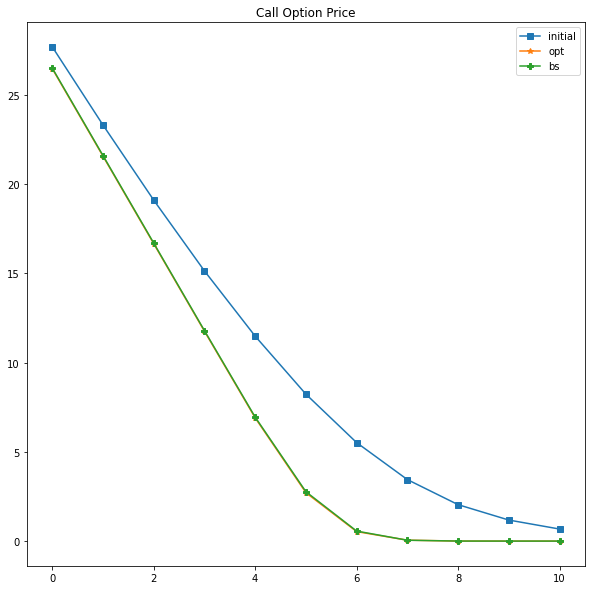

In [31]:
plt.figure(figsize=(10,10))
plt.plot(call_price,'s-',label='initial')
plt.plot(opt_call_price,'*-',label='opt')
plt.plot(bs_price,'P-',label='bs')
plt.legend()
plt.title('Call Option Price')
plt.show()

In [32]:
diff1 = []
diff2 = []
for i in range(len(call_price)):
    d1 = abs(bs_price[i] - call_price[i])
    d2 = abs(bs_price[i] - opt_call_price[i])
    diff1.append(d1)
    diff2.append(d2)

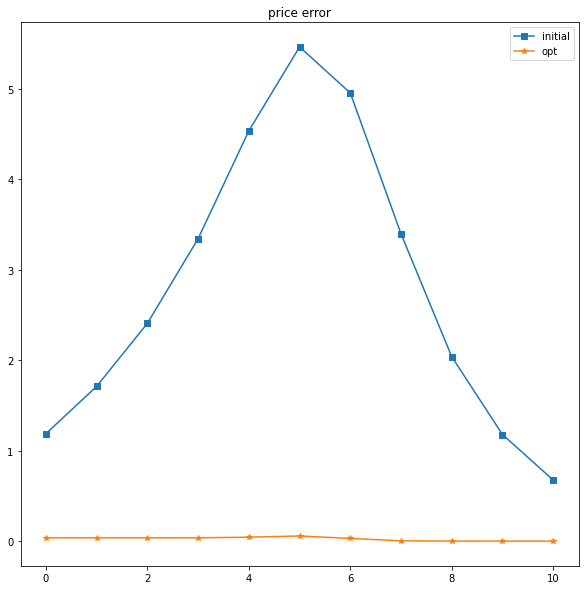

In [33]:
plt.figure(figsize=(10,10))
plt.plot(diff1,'s-',label='initial')
plt.plot(diff2,'*-',label='opt')
plt.legend()
plt.title('price error')
plt.show()